In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib.patches as mpatches

def plot_av_vs_as(gdf: gpd.GeoDataFrame, As_Kategorie: str, Kategorie: str, Titel: str):
    """
    Vergleicht zwei Kategorisierungsspalten in einem GeoDataFrame
    und erstellt eine Karte + Balkendiagramm mit Übereinstimmungsraten.

    Parameters
    ----------
    gdf : GeoDataFrame
        GeoDataFrame mit Polygonen und den Kategoriespalten.
    As_Kategorie : str
        Name der ersten Kategorie-Spalte (z.B. "IPCC_AV_Id").
    Kategorie : str
        Name der zweiten Kategorie-Spalte (z.B. "IPCC_AS_Id").
    """

    # Sicherstellen, dass CRS metrisch ist (EPSG:2056)
    if gdf.crs is None or gdf.crs.to_epsg() != 2056:
        gdf = gdf.to_crs(epsg=2056)

    # Farben definieren
    category_colors = {
        1: "#228B22",   # Forest land -> grün
        2: "#8B4513",   # Cropland -> braun
        3: "#BCFF1E",   # Grassland -> gelb/grün
        4: "#1E90FF",   # Wetlands -> blau
        5: "#A9A9A9",   # Settlements -> grau
        6: "#F31383"    # Other Land -> pink
    }

    def adjust_brightness(color, factor):
        rgb = np.array(to_rgb(color))
        rgb = np.clip(rgb * factor, 0, 1)
        return rgb

    color_low_sat = {k: adjust_brightness(v, 1.5) for k, v in category_colors.items()}  # hell = korrekt
    color_high_sat = {k: adjust_brightness(v, 1.0) for k, v in category_colors.items()} # kräftig = falsch

    # Farbe pro Polygon zuweisen
    def get_color(row):
        a_cat = row[As_Kategorie]
        b_cat = row[Kategorie]
        if a_cat == b_cat:
            return color_low_sat.get(a_cat, "#ffffff")
        else:
            return color_high_sat.get(a_cat, "#ffffff")

    gdf["plot_color"] = gdf.apply(get_color, axis=1)

    # Übereinstimmungsraten pro Kategorie
    accuracy_per_class = []
    for cat in category_colors.keys():
        mask_class = gdf[As_Kategorie] == cat
        correct = np.sum(gdf.loc[mask_class, Kategorie] == cat)
        total = np.sum(mask_class)
        pct = (correct / total * 100) if total > 0 else 0
        accuracy_per_class.append((cat, pct))

    # Karte + Balken plotten
    fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(14, 8), width_ratios=[2, 1])

    # Karte
    gdf.plot(ax=ax_map, color=gdf["plot_color"], edgecolor="none", linewidth=0.2)
    ax_map.set_title(Titel, fontsize=18, fontweight="bold")
    ax_map.axis("on")
    ax_map.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # Maßstab
    xlim = ax_map.get_xlim()
    ylim = ax_map.get_ylim()
    scalebar_length = 1000  # 1000 Meter
    scalebar_x = xlim[0] + (xlim[1]-xlim[0])*0.05
    scalebar_y = ylim[0] + (ylim[1]-ylim[0])*0.02
    ax_map.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='black', linewidth=3)
    ax_map.text(scalebar_x + scalebar_length/2, scalebar_y + (ylim[1]-ylim[0])*0.01, f"{scalebar_length} m",
                ha='center', va='bottom', fontsize=10)

    # Sortierung der Kategorien nach Häufigkeit in As_Kategorie
    category_counts = gdf[As_Kategorie].value_counts()
    ordered_cats = list(category_counts.index)

    # Balkenplot nach geordneter Kategorie
    accuracy_per_class_ordered = [(cat, next(pct for (c, pct) in accuracy_per_class if c == cat))
                                  for cat in ordered_cats]

    for idx, (cat, pct) in enumerate(accuracy_per_class_ordered):
        incorrect_pct = 100 - pct
        ax_bar.barh(idx, pct, color=color_low_sat[cat], edgecolor='black')
        ax_bar.barh(idx, incorrect_pct, left=pct, color=color_high_sat[cat], edgecolor='black')

    # Kategorie-Namen
    category_names = {
        1: "Forest land",
        2: "Cropland",
        3: "Grassland",
        4: "Wetlands",
        5: "Settlements",
        6: "Other Land"
    }

    ax_bar.set_yticks(range(len(ordered_cats)))
    ax_bar.set_yticklabels([f"{category_names[cat]} {pct:.0f}%" for (cat, pct) in accuracy_per_class_ordered])

    # X-Achse
    ax_bar.set_xlim(0, 100)
    ax_bar.set_xlabel("Prozentuale Übereinstimmung")
    ax_bar.set_title("Kategorie mit Prozent Übereinstimmung", fontsize=11, fontweight="bold")

    # Erklärung hell/dunkel horizontal
    legend_patches = [
        mpatches.Patch(color="lightgrey", label="hell = korrekt"),
        mpatches.Patch(color="darkgrey", label="dunkel = falsch")
    ]
    ax_bar.legend(handles=legend_patches, loc="upper center", fontsize=8, ncol=2, frameon=False)

    plt.gca().invert_yaxis()  # Balken von oben nach unten
    plt.tight_layout()
    plt.show()


In [ ]:
# gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\av\AV_As_Center_Pixel.gpkg"
gpkg_path = r"C:\Users\st1179523\Documents\GitHub\landcover_analysis\data\analysis\av\AV_As_Center_Pixel.gpkg"
gdf = gpd.read_file(gpkg_path)

As_Kategorie="IPCC_AS_Id"
Kategorie="IPCC_AV_Id"

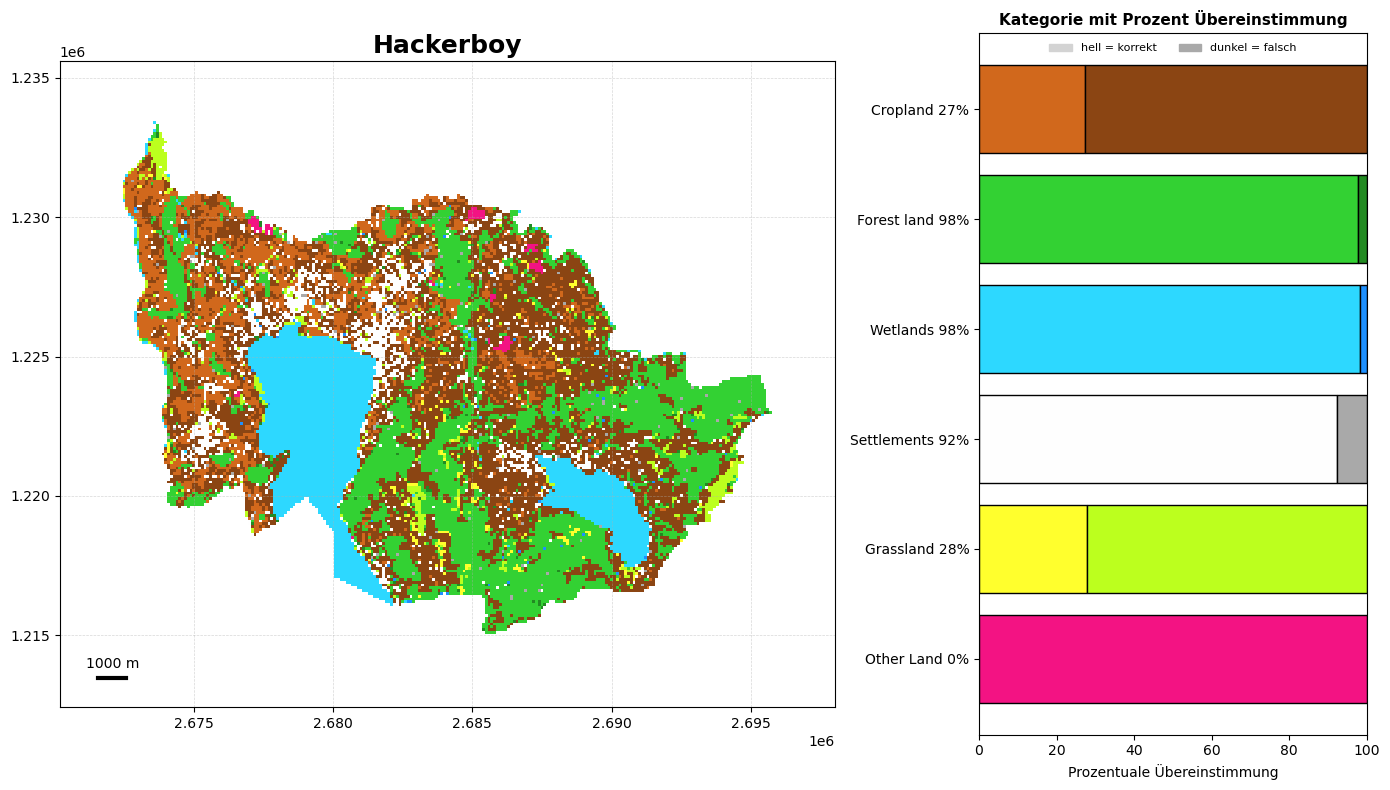

In [ ]:

plot_av_vs_as(gdf,As_Kategorie ,Kategorie, "Hackerboy" )


In [35]:
count_per_category = gdf.groupby(As_Kategorie).size().to_dict()
count_per_category = dict(sorted(count_per_category.items(), key=lambda x: x[1], reverse=True))



print(count_per_category)

{2.0: 11185, 1.0: 6228, 4.0: 3333, 5.0: 2114, 3.0: 908, 6.0: 106}


In [44]:
# Original color mapping by category id
category_colors = {
    1: "#228B22",   # Forest land -> grün
    2: "#8B4513",   # Cropland -> braun
    3: "#BCFF1E",   # Grassland -> gelb/grün
    4: "#1E90FF",   # Wetlands -> blau
    5: "#A9A9A9",   # Settlements -> grau
    6: "#F31383"    # Other Land -> pink
}

# Create a new color mapping that matches the renumbered order
renumbered_colors = {new_id: category_colors[old_id] for new_id, name in renumbered.items()
                     for old_id, old_name in category_names.items() if name == old_name}

print(renumbered_colors)


{1: '#8B4513', 2: '#228B22', 3: '#1E90FF', 4: '#A9A9A9', 5: '#BCFF1E', 6: '#F31383'}
